In [66]:
import numpy as np
from scipy.stats import norm  

In [67]:
# Black-Scholes + Delta, Gamma, Vega
def bs_price_greeks(S, K, T, r, sigma, option_type="call", q=0.0):
    # S : spot
    # K : strike
    # T : maturity (y)
    # r : risk-free rate
    # sigma : vol implicite
    # q : dividende
    # option_type : "call" ou "put"
    
    # d1 et d2 formule 
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T)) 
    # old try:(np.log(S/K)+(r-q-0.3*sigma**2)*T)/(sigma*np.sqrt(T))  # jsp pourquoi j'avais mis -0.3
    d2 = d1 - sigma * np.sqrt(T) 


    
    # pdf et cdf de la normale
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)
    nd1 = norm.pdf(d1)
    
    # Prix + Delta en fonction type d'option
    if option_type == "call":
        price = S * np.exp(-q * T) * Nd1 - K * np.exp(-r * T) * Nd2
        delta = np.exp(-q * T) * Nd1
    elif option_type == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
        delta = np.exp(-q * T) * (Nd1 - 1)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'") 
    
    # gamma formule de base pas cherché plus loin
    gamma = (np.exp(-q * T) * nd1) / (S * sigma * np.sqrt(T))
    
    # Vega (sensibilité au sigma) ne pas oublier sqrt(T)!!
    vega = S * np.exp(-q * T) * nd1 * np.sqrt(T)
    
    return price, delta, gamma, vega

In [68]:
# Paramètres
S0 = 100   #120 too much
K = 100
T = 0.5    # 6 mois 
r = 0.02
sigma = 0.20
q = 0.0
option_type = "call" 

price, delta, gamma, vega = bs_price_greeks(S0, K, T, r, sigma, option_type, q)


print("=== Black-Scholes ===")
print(f"Price : {price:.4f}")
print(f"Delta : {delta:.4f}")
print(f"Gamma : {gamma:.6f}")
print(f"Vega  : {vega:.4f}")


=== Black-Scholes ===
Price : 6.1207
Delta : 0.5562
Gamma : 0.027929
Vega  : 27.9288


In [69]:
import pandas as pd  #visu

# Scénarios stress spot
price_shocks = {
    "+5%": 1.05,
    "-5%": 0.95,
    "+10%": 1.10,
    "-10%": 0.90
}

rows = []

try:
    base_price
except:
    # peut vraiment mieux faire honnetement 
    base_price, base_delta, base_gamma, base_vega = bs_price_greeks(
        S0, K, T, r, sigma, option_type, q
    )
    print("(j'avais oublié base_price donc je le recalcule comme un bourrin)")

# stress test vilain comme tout
for nomScenario in price_shocks.keys():    
    
    facteur = price_shocks[nomScenario]     
    Sstress = S0 * facteur                  
    
    
    pr, dlt, gmm, vg = bs_price_greeks(Sstress, K, T, r, sigma, option_type, q) #hasardeux

    pnl_stress = pr - base_price    

    print("Scénario ==> ", nomScenario)
    print("   spot_stress :", Sstress)
    print("   price :", pr, "| pnl:", pnl_stress)
    print("   delta/gamma/vega :", dlt, gmm, vg)
    print("------------------------------")

    rows.append({
        "scenarioName": nomScenario,
        "stressSpot": Sstress,
        "prix": pr,
        "Delta": dlt,
        "Gamma": gmm,
        "Vega": vg,
        "PNL": pnl_stress
    })

# comment ca marche? je n'en ai pas la moindre idée. (lol)

df_price = pd.DataFrame(rows)
print("\n=== Tableau des stress spot ===")
print(df_price)


Scénario ==>  +5%
   spot_stress : 105.0
   price : 9.236413420755888 | pnl: 3.1157593073000456
   delta/gamma/vega : 0.6866652634754383 0.02386864639029873 26.315182645304354
------------------------------
Scénario ==>  -5%
   spot_stress : 95.0
   price : 3.6967635884087713 | pnl: -2.423890525047071
   delta/gamma/vega : 0.4124383761346612 0.028976049227637444 26.1508844279428
------------------------------
Scénario ==>  +10%
   spot_stress : 110.00000000000001
   price : 12.945959260654917 | pnl: 6.825305147199074
   delta/gamma/vega : 0.7925686087754575 0.018392389106658354 22.254790819056613
------------------------------
Scénario ==>  -10%
   spot_stress : 90.0
   price : 1.988984652704982 | pnl: -4.13166946075086
   delta/gamma/vega : 0.2730581332276878 0.026124096797086768 21.160518405640286
------------------------------

=== Tableau des stress spot ===
  scenarioName  stressSpot       prix     Delta     Gamma       Vega       PNL
0          +5%       105.0   9.236413  0.68666

In [70]:
# Scénarios stress volatilité 
vol_shocks = {
    "+5pts": 0.05,   # 20% 25%
    "-5pts": -0.05,  # 20% 15%
    "+10pts": 0.10,  # 20% 30%
    "-10pts": -0.10  # 20% 10%
}

rows_vol = []


try:
    base_price
except:
    base_price, base_delta, base_gamma, base_vega = bs_price_greeks(S0, K, T, r, sigma, option_type, q)
    print("(j'avais oublié base_price donc je le recalcule ici aussi...)")

for nom_scen_vol in vol_shocks:    # tjr pas de .item j'ai des outils mais je prefere utiliser mes pieds
    decalage_vol = vol_shocks[nom_scen_vol]  

    sigma_stressé = sigma + decalage_vol   # marrant nan?
    
    if sigma_stressé <= 0:    # sinn BS explose, merci chat gpt
        sigma_stressé = 0.0001   

    try:   
        p_st, d_st, g_st, v_st = bs_price_greeks(S0, K, T, r, sigma_stressé, option_type, q)
    except:
        print("problème bizarre avec sigma =", sigma_stressé)
        p_st, d_st, g_st, v_st = None, None, None, None   # technique de barbare ca

    pnl_st = p_st - base_price

    print("VOL ->", nom_scen_vol)
    print("   nouvelleVol =", sigma_stressé)
    print("   price =", p_st, "  pnl =", pnl_st)
    print("   greeks :", d_st, g_st, v_st)
    print("----------------------------------------")

    rows_vol.append({
        "nomScenarioVol" : nom_scen_vol,    
        "volStressée" : sigma_stressé, # RIP CSV
        "spotRef" : S0,                    
        "prix_après" : p_st,  # incohérent 
        "Delta" : d_st,
        "Gamma" : g_st,
        "Vega" : v_st,
        "PNL_stress" : pnl_st               
    })


df_vol = pd.DataFrame(rows_vol)
print("\n=== Tableau des stress vol ===")
print(df_vol)


VOL -> +5pts
   nouvelleVol = 0.25
   price = 7.5168463739128555   pnl = 1.3961922604570134
   greeks : 0.5576275455577764 0.02233172383841429 27.914654798017867
----------------------------------------
VOL -> -5pts
   nouvelleVol = 0.15000000000000002
   price = 4.724578170995336   pnl = -1.3960759424605058
   greeks : 0.5585578742493529 0.03720672187465184 27.90504140598889
----------------------------------------
VOL -> +10pts
   nouvelleVol = 0.30000000000000004
   price = 8.91178851134395   pnl = 2.791134397888108
   greeks : 0.5608822719131072 0.018586896501514558 27.880344752271846
----------------------------------------
VOL -> -10pts
   nouvelleVol = 0.1
   price = 3.3318417618525515   pnl = -2.7888123516032906
   greeks : 0.5701581024006669 0.05554426347983313 27.772131739916567
----------------------------------------

=== Tableau des stress vol ===
  nomScenarioVol  volStressée  spotRef  prix_après     Delta     Gamma  \
0          +5pts         0.25      100    7.516846  0

In [71]:
# Fusion price + vol pour avoir le tableay
df_all = pd.concat([df_price, df_vol], ignore_index=True)

# Export CSV
df_all.to_csv("option_greeks_stress_results.csv", index=False) 
print("\n>>> CSV exporté : option_greeks_stress_results.csv")



>>> CSV exporté : option_greeks_stress_results.csv


>> Graph sauvegardé


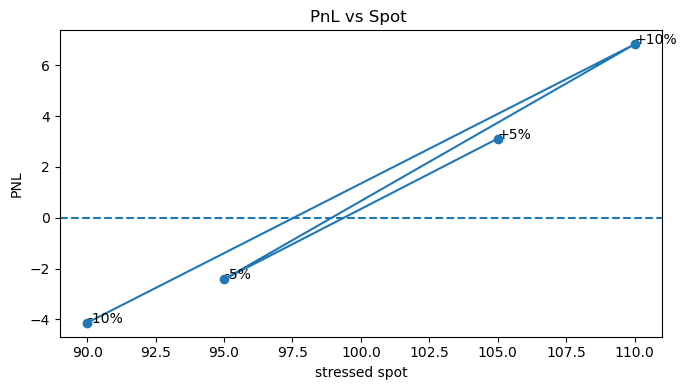

In [72]:
import matplotlib.pyplot as plt

# 1 PnL en fonction de S*
plt.figure(figsize=(7,4)) # 7x4 totalement au hasard 
plt.plot(df_price["stressSpot"], df_price["PNL"], marker="o")


for i, row in df_price.iterrows():
    plt.annotate(row["scenarioName"], (row["stressSpot"], row["PNL"]))

plt.axhline(0, linestyle="--")
plt.xlabel("stressed spot")
plt.ylabel("PNL")
plt.title("PnL vs Spot ")
plt.tight_layout()
plt.savefig("pnl_vs_spot.png")

print(">> Graph sauvegardé")


>> Graphique pnl_vs_vol.png sauvegardé


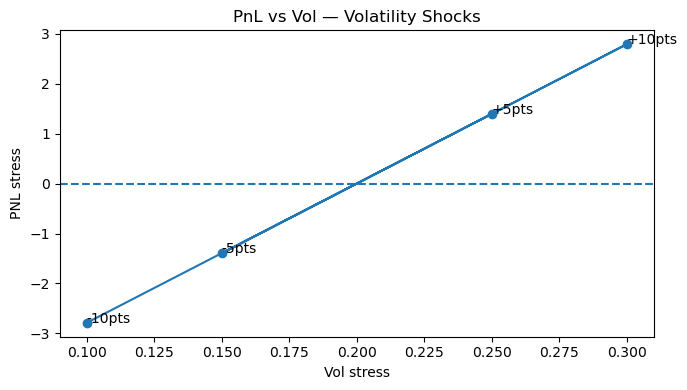

In [73]:
# 2 PnL en fonction de sigma*
plt.figure(figsize=(7,4))

# X = vol stressée
# Y = PNL stress
plt.plot(df_vol["volStressée"], df_vol["PNL_stress"], marker="o")

# annotations
for i, row in df_vol.iterrows():
    plt.annotate(row["nomScenarioVol"], (row["volStressée"], row["PNL_stress"]))

plt.axhline(0, linestyle="--")
plt.xlabel("Vol stress")
plt.ylabel("PNL stress")
plt.title("PnL vs Vol — Volatility Shocks")
plt.tight_layout()
plt.savefig("pnl_vs_vol.png")

print(">> Graphique pnl_vs_vol.png sauvegardé")


>> Graph stress_pnl_barplot.png saved


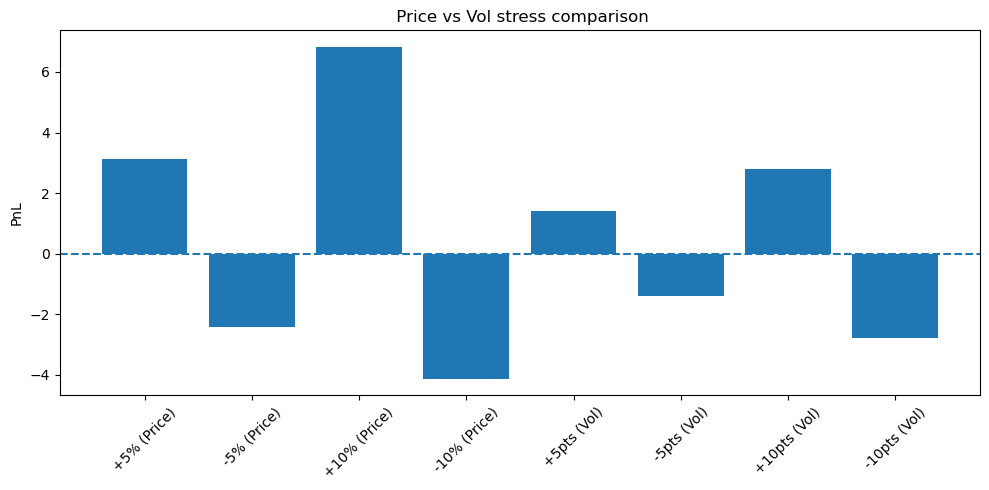

In [74]:
# 3 comparatif des scénarios
labels = list(df_price["scenarioName"]) + list(df_vol["nomScenarioVol"])

pnl_values = list(df_price["PNL"]) + list(df_vol["PNL_stress"])

types = ["Price"] * len(df_price) + ["Vol"] * len(df_vol)

plt.figure(figsize=(10,5))
x = range(len(labels))

plt.bar(x, pnl_values)

plt.xticks(x, [f"{lab} ({typ})" for lab, typ in zip(labels, types)], rotation=45)
plt.axhline(0, linestyle="--")
plt.ylabel("PnL")
plt.title(" Price vs Vol stress comparison")
plt.tight_layout()
plt.savefig("stress_pnl_barplot.png")

print(">> Graph stress_pnl_barplot.png saved")


In [75]:
!jupyter nbconvert --to script option_greeks_shock_model.ipynb


[NbConvertApp] Converting notebook option_greeks_shock_model.ipynb to script
[NbConvertApp] Writing 6758 bytes to option_greeks_shock_model.py
